# 自己操作

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [3]:
file_path=r'E:\Data analysis\CDA\learning\0、python自己练习\6、机器学习\data'
os.chdir(file_path)

## 第一步，读取数据

In [5]:
data=pd.read_csv('titanic_train.csv')
#data.head(2)
#data.info()

#部分字段解释：
    #Pclass: 船舱等级
    #SibSp:携带兄弟姐妹数量
    #Parch:携带父母和小孩数量
    #Fare：票价
    #Ticket：船票号
    #Embarked：登船地点
data_copy=data.copy()

In [106]:
data_copy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Respect_name,Age_cut,Age_new
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,4,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,4,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,4,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,4,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,4,35.0


In [103]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 第二步，对数据进行清洗工作

In [6]:
# 先用正则表达式提取name中的敬称
reg=re.compile('.*?,(.*?)\..*?',re.S)
data_copy['Respect_name']=data_copy['Name'].map(lambda x:reg.findall(x)[0].strip())

#处理Respect_name不合理的数据  Respect_name=Jonkheer Mme Rev Col   
data_copy['Respect_name']=data_copy['Respect_name'].str.replace('Jonkheer','Mrs')
data_copy['Respect_name']=data_copy['Respect_name'].str.replace('Mme','Miss')
data_copy['Respect_name']=data_copy['Respect_name'].str.replace('Ms','Miss')
data_copy['Respect_name']=data_copy['Respect_name'].str.replace('Mlle','Miss')
data_copy['Respect_name']=data_copy['Respect_name'].str.replace('Rev','Mr')
data_copy['Respect_name']=data_copy['Respect_name'].str.replace('Col','Mr')


# 处理Embarked中的缺失值，用众数填充
data_copy['Embarked'].fillna(data_copy['Embarked'].value_counts().index[0],axis=0,inplace=True)


#对年龄分组0（初生）-6岁为婴幼儿(1)；7-12岁为少儿(2)；13-17岁为青少年(3)；18-45岁为青年(4)；
#          46-69岁为中年(5)；>69岁为老年(6)
data_copy['Age_cut']=pd.cut(data_copy['Age'],[0,7,13,18,46,70,200],labels=[1,2,3,4,5,6])

#处理Age中的缺失值
data_copy['Age_new']=data_copy['Age']
female_mean=data_copy[data_copy['Sex']=='female'].groupby('Age_cut').count()['Sex'].describe()[1]
male_mean=data_copy[data_copy['Sex']=='male'].groupby('Age_cut').count()['Sex'].describe()[1]

#处理Age缺失值函数
def f1(x):
    if x['Sex']=='female' and pd.isna(x['Age_new']):
        x['Age_new']=female_mean
    elif x['Sex']=='male' and pd.isna(x['Age_new']):
        x['Age_new']=male_mean
    return x
data_copy['Age_new']=data_copy.apply(f1,axis=1)['Age_new']



## 第三步，提取数据集并预处理

In [7]:
#提取数据集
X=data_copy[[ 'Pclass', 'Sex', 'SibSp','Parch', 'Fare', 'Embarked', 'Respect_name', 'Age_new']]
Y=data_copy['Survived']

#将分类变量转换为数值型变量
#将二分类变量转换为数值型变量方法：
    #astype能够将一个pandas对象转换为某种类型，和apply(int(x))不同，astype可以将文本类转换为数字，
    #      用这个方式可以很便捷地将二分类特征转换为0~1
# Sex:1→male,0→female
X['Sex']=(X['Sex']=='male').astype('int')

#将多类别变量转换为数值型变量方法：把本列数据用unique方法取出并用tolist转换为列表，再使用值对应列表的index替换
Embarked_labels=X['Embarked'].unique().tolist()
Respect_name_labels=X['Respect_name'].unique().tolist()
X['Embarked']=X['Embarked'].map(lambda x:Embarked_labels.index(x))
X['Respect_name']=X['Respect_name'].map(lambda x:Respect_name_labels.index(x))


D:\tool\anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
D:\tool\anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
D:\tool\anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

## 第四步，跑模型

### 初步跑模型

In [8]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,Y,test_size=0.3,random_state=420)
clf_original=tree.DecisionTreeClassifier()
clf_original=clf_original.fit(Xtrain,Ytrain)
score_original=clf_original.score(Xtest,Ytest)

score_cross_orig=cross_val_score(clf_original,Xtrain,Ytrain,cv=10).mean()
var_cross_orig=cross_val_score(clf_original,Xtrain,Ytrain,cv=10).var()

print('初步模型：效果{},交叉验证效果{},交叉验证方差{}'.format(score_original,score_cross_orig,var_cross_orig))

初步模型：效果0.753731343283582,交叉验证效果0.7592293906810035,交叉验证方差0.0029335418711037126


### 在不同max_depth下观察模型的拟合状况

不同max_depth下模型：效果0.9871589085072231,交叉验证效果0.8009112583205324


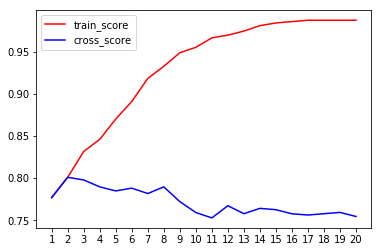

In [9]:
train_score_depth=[]
cross_score_depth=[]
for i in range(1,21):
    clf_depth=tree.DecisionTreeClassifier(max_depth=i)
    clf_depth=clf_depth.fit(Xtrain,Ytrain)
    train_score_depth.append(clf_depth.score(Xtrain,Ytrain))
    cross_score_depth.append(cross_val_score(clf_depth,Xtrain,Ytrain,cv=10).mean())
print('不同max_depth下模型：效果{},交叉验证效果{}'.format(max(train_score_depth),max(cross_score_depth)))
plt.plot(range(1,21),train_score_depth,color='red',label='train_score')
plt.plot(range(1,21),cross_score_depth,color='blue',label='cross_score')
plt.xticks(range(1,21))
plt.legend()
plt.show()

### 使用网格搜索方法调整参数

In [10]:
parameters={'criterion':['gini','entropy'],
            'splitter':['best','random'],
           'max_depth':range(1,21),  
            'min_samples_split':range(2,40,2),
           'min_samples_leaf':range(1,50,5)
            #'min_impurity_decrease':np.linspace(0,0.5,20) 跑过一次没有意义
           }
clf_grid=tree.DecisionTreeClassifier()
gs=GridSearchCV(estimator=clf_grid,param_grid=parameters,cv=10)
gs.fit(Xtrain,Ytrain)
print('最佳分数',gs.best_score_)
print('最佳参数',gs.best_params_)

最佳分数 0.826645264847512
最佳参数 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 36, 'min_samples_split': 2, 'splitter': 'best'}


D:\tool\anaconda\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [186]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 36,
 'splitter': 'best'}

### 优化模型

In [12]:
clf_best=tree.DecisionTreeClassifier(criterion=gs.best_params_['criterion'],max_depth=gs.best_params_['max_depth'],
                                    splitter=gs.best_params_['splitter'],min_samples_leaf=gs.best_params_['min_samples_leaf'],
                                    min_samples_split=gs.best_params_['min_samples_split']
                                    )
clf_best=clf_best.fit(Xtrain,Ytrain)
score_best=clf_best.score(Xtest,Ytest)

cross_score_best=cross_val_score(clf_best,Xtrain,Ytrain,cv=10).mean()
cross_score_var=cross_val_score(clf_best,Xtrain,Ytrain,cv=10).var()

print('优化模型：效果{},交叉验证效果{},交叉验证方差{}'.format(score_best,cross_score_best,cross_score_var))


优化模型：效果0.832089552238806,交叉验证效果0.8266921082949308,交叉验证方差0.0036025515368006576


### 使用混淆矩阵评估模型
- 因我们遇到的问题是二分类问题，可以使用混淆矩阵

In [13]:
from sklearn import metrics

best_ypredict=clf_best.predict(Xtest)
original_ypredict=clf_original.predict(Xtest)

original_acc_score=metrics.accuracy_score(Ytest,original_ypredict)
original_pre_score=metrics.precision_score(Ytest,original_ypredict)
original_f1_score=metrics.f1_score(Ytest,original_ypredict)

best_acc_score=metrics.accuracy_score(Ytest,best_ypredict)
best_pre_score=metrics.precision_score(Ytest,best_ypredict)
best_f1_score=metrics.f1_score(Ytest,best_ypredict)

print('         优化前模型\t\t\t\t优化后模型')
print('准确率   {}\t\t\t{}'.format(original_acc_score,best_acc_score))
print('精度     {}\t\t\t{}'.format(original_pre_score,best_pre_score))

         优化前模型				优化后模型
准确率   0.753731343283582			0.832089552238806
精度     0.7102803738317757			0.8367346938775511


### 画决策树图

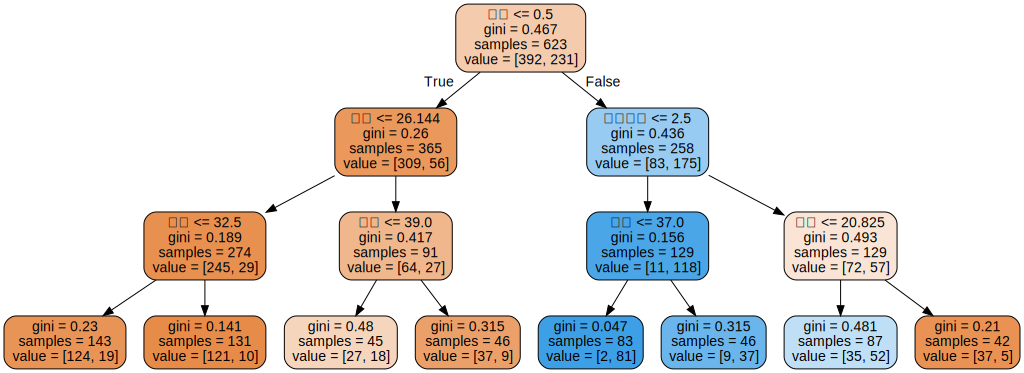

In [14]:
feature_name=['船舱等级', '性别', '兄弟姐妹数量', '父母小孩数量', '票价', '登船地点', '头衔','年龄']

dot_data=tree.export_graphviz(clf_best,feature_names=feature_name,
                              filled=True,rounded=True)
grahp=graphviz.Source(dot_data)
grahp

# 课堂老师指导

## 导入包和数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight') #设置画图样式

import warnings
warnings.filterwarnings('ignore') #屏蔽警告说明

In [2]:
data=pd.read_csv(r'E:\Data analysis\CDA\learning\0、python自己练习\6、机器学习\data\titanic_train.csv')
#data.head(2)
#data.info()

#部分字段解释：
    #Pclass: 船舱等级
    #SibSp:携带兄弟姐妹数量
    #Parch:携带父母和小孩数量
    #Fare：票价
    #Ticket：船票号
    #Embarked：登船地点
data_copy=data.copy()

## 查看统计描述内容

In [5]:
data_copy.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 探索数据

In [6]:
data_copy.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

### 画图查看 标签比例 获救比例情况

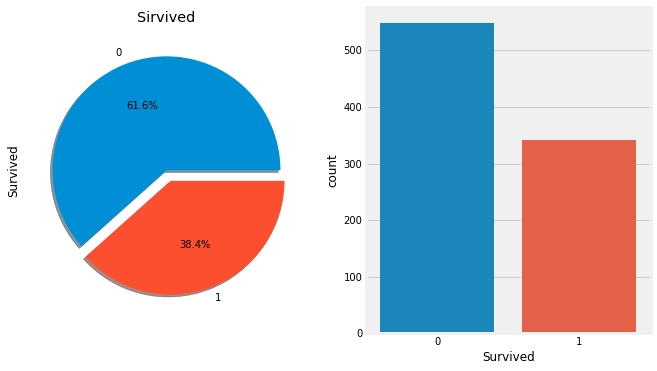

In [7]:
f,ax=plt.subplots(1,2,figsize=(10,6))
#explode:设置偏移；autopct：显示标签格式；shadow：True表示添加阴影
data_copy['Survived'].value_counts().plot.pie(ax=ax[0],explode=[0,0.1],
                                             autopct='%1.1f%%',shadow=True)
ax[0].set_title('Sirvived')

sns.countplot('Survived',data=data_copy,ax=ax[1])

### 分析X与Y间的关系

#### 不同性别下存活人数

In [8]:
data_copy.groupby(['Survived','Sex'])['Survived'].count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Survived, dtype: int64

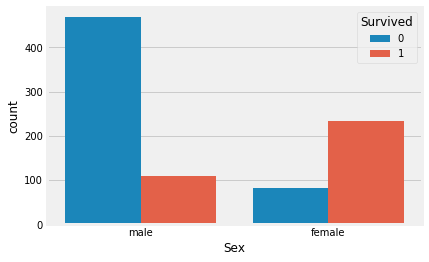

In [9]:
#使用组合柱状图
#hue是对哪个列计数
sns.countplot('Sex',hue='Survived',data=data_copy)

#### Pclass 和获救间的关系

In [10]:
#pd.crosstab(行，列，margins):margins=True是对行列求和
#cmap:winter_r是冬天，autumn_r是秋天，spring_r 是春天,summer_r是夏天
pd.crosstab(data_copy.Pclass,data_copy.Survived,margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


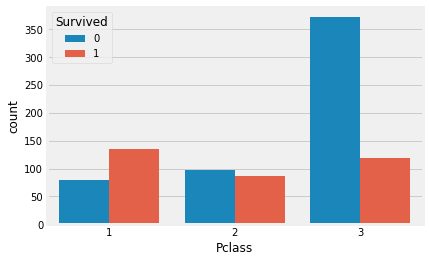

In [11]:
sns.countplot('Pclass',hue='Survived',data=data_copy)

### 多变量分析

In [12]:
pd.crosstab([data_copy.Sex,data_copy.Survived],data_copy.Pclass,margins=True).style.background_gradient(cmap='summer_r')

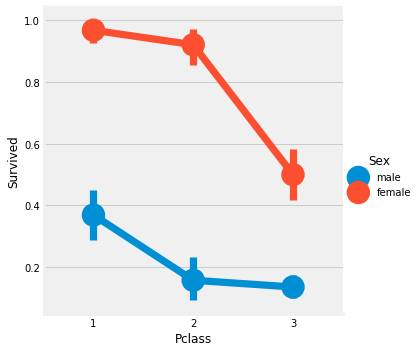

In [13]:
# 三个变量画图
sns.factorplot('Pclass','Survived',hue='Sex',data=data_copy)

## 数据清洗和预处理

### 处理年龄缺失值

#### 先提取名称中有用的信息

In [14]:
data_copy['initial']=data_copy.Name.str.extract('([A-Za-z]+)\.')

In [15]:
pd.crosstab(data_copy.initial,data.Sex).T

initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [16]:
re=[]
for i in data_copy.initial.values:
    if i!='Master' and i!='Miss' and i!='Mr' and i!='Mrs':
        re.append(i.replace(i,'other'))
    else:
        re.append(i)

In [17]:
set(re)

{'Master', 'Miss', 'Mr', 'Mrs', 'other'}

In [18]:
data_copy['re']=re

#### 利用提取的数据和已有年龄数据分组求平均值填充缺失值

In [19]:
data_copy.groupby('re')['Sex'].count()

re
Master     40
Miss      182
Mr        517
Mrs       125
other      27
Name: Sex, dtype: int64

In [20]:
data_copy.groupby(['re','Sex'])['Sex'].count()

re      Sex   
Master  male       40
Miss    female    182
Mr      male      517
Mrs     female    125
other   female      7
        male       20
Name: Sex, dtype: int64

In [21]:
int(data_copy.groupby('re')['Age'].mean()['Master'])

4

In [22]:
data_copy.groupby('re')['Age'].mean()

re
Master     4.574167
Miss      21.773973
Mr        32.368090
Mrs       35.898148
other     42.384615
Name: Age, dtype: float64

In [23]:
for i in data_copy.re.values:
    data_copy.loc[(data_copy.Age.isna())&(data_copy.re==i),'Age']=int(data_copy.groupby('re')['Age'].mean()[i])

In [24]:
data_copy.Age.isna().any()

False

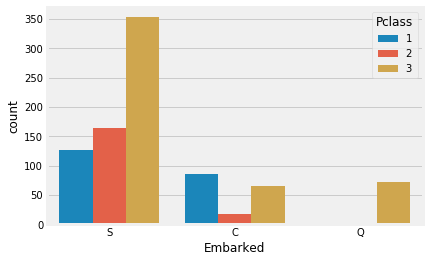

In [25]:
sns.countplot('Embarked',hue='Pclass',data=data_copy)

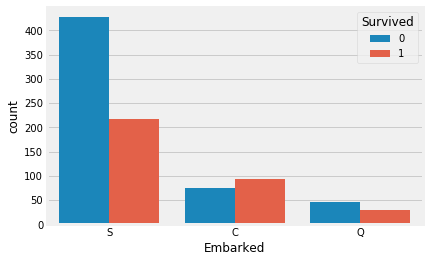

In [26]:
sns.countplot('Embarked',hue='Survived',data=data_copy)

In [27]:
data_copy['Embarked'].fillna('S',inplace=True)

In [28]:
data_copy.Embarked.isna().any() #判断是否还存在缺失值

False

#### 查看连续变量分布情况

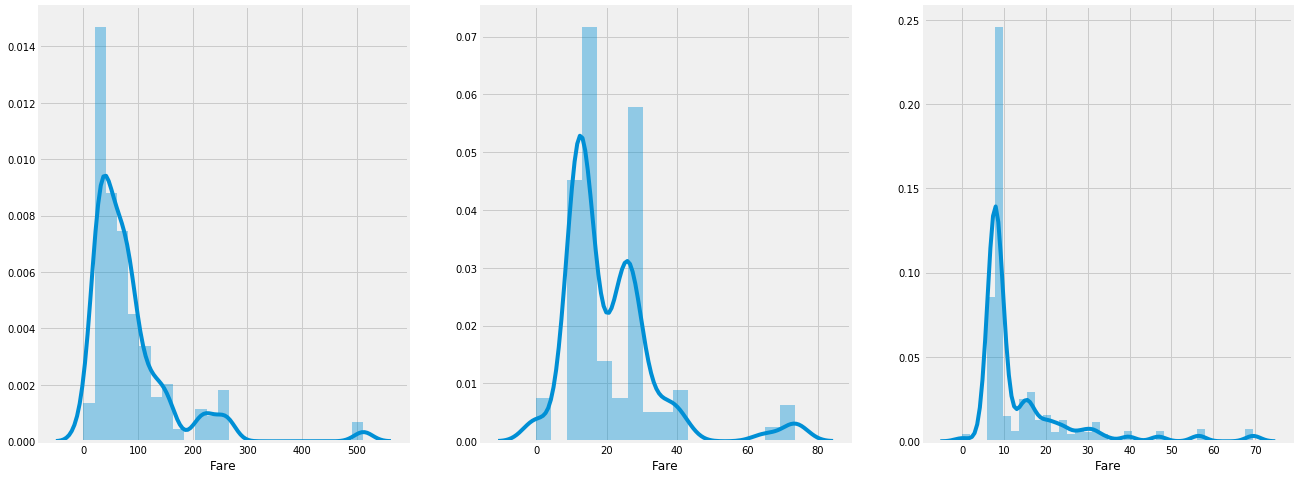

In [29]:
f,ax=plt.subplots(1,3,figsize=(20,8))
#画直方图
sns.distplot(data_copy[data_copy['Pclass']==1].Fare,ax=ax[0])
sns.distplot(data_copy[data_copy['Pclass']==2].Fare,ax=ax[1])
sns.distplot(data_copy[data_copy['Pclass']==3].Fare,ax=ax[2])


## 分析特征之间的相关性

### 相关性热图

In [30]:
# 皮尔逊相关系数
data_copy.corr()   

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.043358,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.089369,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.346011,0.083081,0.018443,-0.549500
Age,0.043358,-0.089369,-0.346011,1.000000,-0.268632,-0.195330,0.092215
SibSp,-0.057527,-0.035322,0.083081,-0.268632,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.195330,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.092215,0.159651,0.216225,1.000000


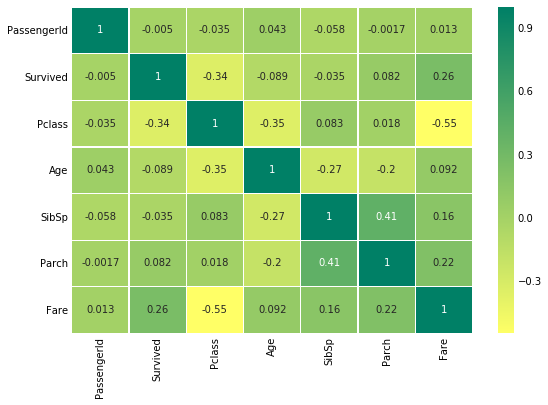

In [31]:
sns.heatmap(data_copy.corr(),annot=True,linewidths=0.2,cmap='summer_r')
fig=plt.gcf()
fig.set_size_inches(8,6)
plt.savefig(r'E:\Data analysis\CDA\learning\0、python自己练习\6、机器学习\filesave\heattmap.png')

### 数据预处理

#### 年龄分箱处理

In [32]:
data_copy['Age_band']=0
data_copy.loc[data_copy['Age']<=16,'Age_band']=0
data_copy.loc[(data_copy['Age']<=32)&(data_copy['Age']>16),'Age_band']=1
data_copy.loc[(data_copy['Age']<=48)&(data_copy['Age']>32),'Age_band']=2
data_copy.loc[(data_copy['Age']<=65)&(data_copy['Age']>48),'Age_band']=3
data_copy.loc[data_copy['Age']>65,'Age_band']=4
data_copy.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,initial,re,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr,2


### 其他变量数值化处理
- 使用sklearn.preprocessing.LabelEncoder()

In [33]:
from sklearn import preprocessing
lbl=preprocessing.LabelEncoder()

In [34]:
data_copy['Sex']=lbl.fit_transform(data_copy['Sex'])
data_copy['Embarked']=lbl.fit_transform(data_copy['Embarked'])
data_copy['re']=lbl.fit_transform(data_copy['re'])

In [35]:
data_copy['Embarked'].unique()

array([2, 0, 1], dtype=int64)

#### 使用独热编码处理，必须是数值型数据

In [36]:
one_hot=preprocessing.OneHotEncoder(sparse=False)  #先实例化  sparse=False表示不升维
data_copy['Embarked']=one_hot.fit_transform(data_copy[['Embarked']])  #必须是二维数据

In [37]:
data_copy['Embarked'].unique()

array([0., 1.])

In [38]:
data_copy.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'initial', 're',
       'Age_band'],
      dtype='object')

In [39]:
data_model=data_copy[[ 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 're', 'Age_band']].copy()

## 建模

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [41]:
data_model.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,re,Age_band
0,0,3,1,22.0,1,0,7.2500,0.0,2,1
1,1,1,0,38.0,1,0,71.2833,1.0,3,2
2,1,3,0,26.0,0,0,7.9250,0.0,1,1
3,1,1,0,35.0,1,0,53.1000,0.0,3,2
4,0,3,1,35.0,0,0,8.0500,0.0,2,2


In [42]:
X=data_model.iloc[:,data_model.columns!='Survived']
y=data_model.iloc[:,data_model.columns=='Survived']

In [43]:
Xtrain,Xtest,Ytrain,Ytest=train_test_split(X,y,test_size=0.2,
                                          random_state=10)

### 逻辑回归

In [44]:
l=LogisticRegression()
l.fit(Xtrain,Ytrain)
l.score(Xtest,Ytest)

0.8212290502793296

In [45]:
pred_1=l.predict(Xtest)
metrics.accuracy_score(Ytest,pred_1)  #和上面一样的结果

0.8212290502793296

### k-NN调参

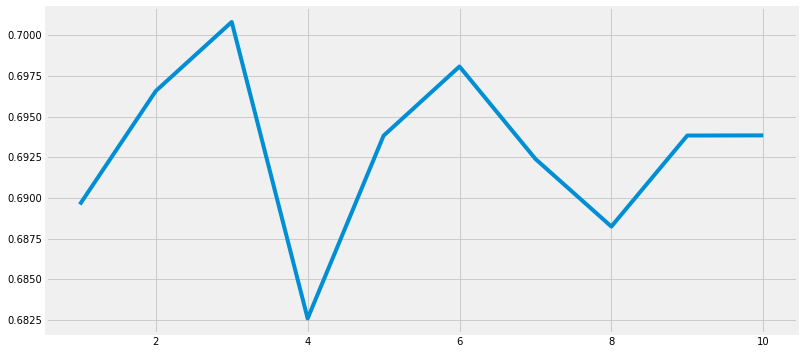

In [46]:
score=[]

for i in range(1,11):
    KNN=KNeighborsClassifier(n_neighbors=i)
    CVS=cross_val_score(KNN,Xtrain,Ytrain,cv=5)
    score.append(CVS.mean())

plt.plot([*range(1,11)],score)
fig=plt.gcf()
fig.set_size_inches(12,6)

In [47]:
max(score),score.index(max(score))+1

(0.7008174923667883, 3)

In [48]:
KNN=KNeighborsClassifier(n_neighbors=3)
KNN.fit(Xtrain,Ytrain)
KNN.score(Xtest,Ytest)

0.6983240223463687

## 决策树

### 网格搜索调参

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
#设置可选参数
param_grid={'criterion':['entropy','gini'],
           'max_depth':range(2,10),
           'min_samples_leaf':range(1,10),
           'min_samples_split':range(2,10)}
#设置网格
GR=GridSearchCV(DecisionTreeClassifier(),param_grid=param_grid,cv=5)

#建模
GR.fit(Xtrain,Ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['entropy', 'gini'], 'max_depth': range(2, 10), 'min_samples_leaf': range(1, 10), 'min_samples_split': range(2, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
#输出接口
GR.best_score_

0.8216292134831461

In [52]:
GR.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 6}

### 建决策树模型

In [54]:
DTC=DecisionTreeClassifier(criterion='entropy',max_depth=4, 
                           min_samples_leaf= 1, min_samples_split=6).fit(Xtrain,Ytrain)
DTC.score(Xtest,Ytest)

0.8324022346368715

In [56]:
DTC.feature_importances_

array([0.20862092, 0.47894285, 0.10411293, 0.0905303 , 0.        ,
       0.11779301, 0.        , 0.        , 0.        ])

### 通过图示查看重要特征

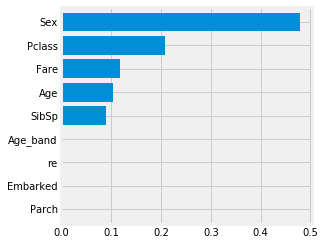

In [55]:
f = plt.figure(figsize=(4,4))
pd.Series(DTC.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8)

In [58]:
y_pred=DTC.predict(Xtest)

### 画ROC曲线

In [57]:
import seaborn as sns
from sklearn.metrics import roc_curve,auc    #计算roc和auc

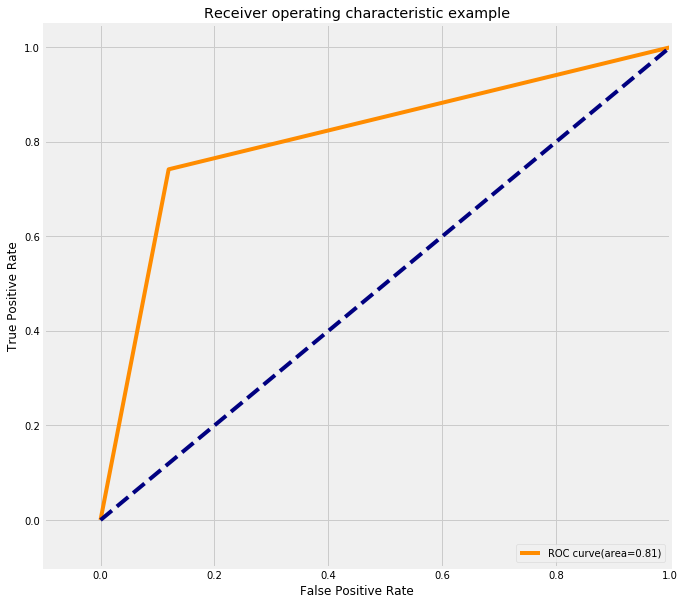

In [65]:
#计算真正率和假正率

fpr,tpr,threshold=roc_curve(Ytest,y_pred)
roc_auc=auc(fpr,tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,color='darkorange',
        label='ROC curve(area=%0.2f)'%roc_auc) # 假正率是横坐标，真正率是纵坐标
plt.plot([0,1],[0,1],color='navy',linestyle='--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')

### 画混淆矩阵图

In [66]:
from sklearn.model_selection import cross_val_predict

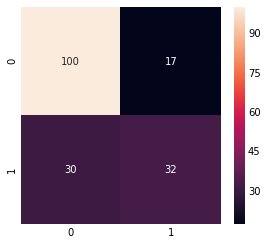

In [71]:
plt.figure(figsize=(4,4))

y_pred=cross_val_predict(KNeighborsClassifier(n_neighbors=3),Xtest,Ytest,cv=10)
sns.heatmap(confusion_matrix(Ytest,y_pred),annot=True,fmt='2.0f')

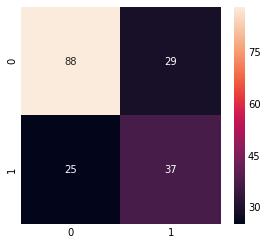

In [69]:
plt.figure(figsize=(4,4))
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(Xtrain,Ytrain)
y_pred =KNN.predict(Xtest)
sns.heatmap(confusion_matrix(Ytest,y_pred),annot=True,fmt='2.0f')

In [ ]:
### 集成算法

In [72]:
from sklearn.ensemble import BaggingClassifier  #装袋集成算法，另外还有提升集成算法(BoostingClassifier)

In [73]:
#base_estimator,待集成的模型;n_estimators 迭代次数,random_state设置数值可以提升模型的稳定性
model=BaggingClassifier(base_estimator=DTC,
                       n_estimators=700,
                       random_state=0)
model.fit(Xtrain,Ytrain)
model.score(Xtest,Ytest)

0.8547486033519553

(179,)

(179, 9)